In [187]:
import torch
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [188]:
import random 
seed = random.randint(1, 1000000)  # 213
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [189]:
class BaselineModel(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) 
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [190]:
model = BaselineModel(input_shape=3, 
    hidden_units=10, 
    output_shape=10).to(device)
model

BaselineModel(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=10, bias=True)
  )
)

In [191]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [192]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [193]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [194]:
def print_train_time(start, end, device=None):
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


In [195]:
cinic_directory = '../data'
cinic_train = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train',
    	transform=transforms.ToTensor()),
    batch_size=64, shuffle=True)

cinic_test = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/test',
    	transform=transforms.ToTensor()),
    batch_size=64, shuffle=True)

In [196]:
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=cinic_train, 
        model=model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=cinic_test,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.00030 | Train accuracy: 25.81%


 33%|███▎      | 1/3 [00:19<00:38, 19.48s/it]

Test loss: 1.83099 | Test accuracy: 34.86%

Epoch: 1
---------
Train loss: 1.66423 | Train accuracy: 39.24%


 67%|██████▋   | 2/3 [00:39<00:19, 19.53s/it]

Test loss: 1.69494 | Test accuracy: 39.67%

Epoch: 2
---------
Train loss: 1.55425 | Train accuracy: 43.68%


100%|██████████| 3/3 [00:58<00:00, 19.48s/it]

Test loss: 1.63044 | Test accuracy: 40.63%


Train time on cuda: 58.442 seconds


Batch 32   - 65 second        test acc 38%/44%   
Batch 64   - 59 second        test acc 39%/41%   
Batch 128  - 55 second        test acc 29%/28%       
Batch 512  - 53 second  
Batch 2048 - 54 second        test acc 10%

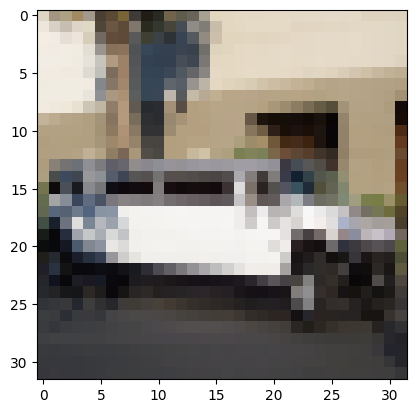

Label: automobile


In [197]:
images, labels = next(iter(cinic_train))

first_image = images[0]
first_label = labels[0] 

plt.imshow(first_image.permute(1, 2, 0))  # Convert from CHW to HWC for plotting
plt.show()

class_names = list(cinic_train.dataset.classes)
label_name = class_names[first_label.item()]
print(f"Label: {label_name}")

In [198]:
first_image.shape

torch.Size([3, 32, 32])